# VDSR tensorflow-v2 implementation

In [2]:
import cv2
import os
import sys
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt

# VDSR model

**Training phase:**

**Input**: 41x41x3 patch of lr_images

**Model**: Input layer -> 19 (conv+relu) layers -> residual layer

**Output**: corresponding hr patch

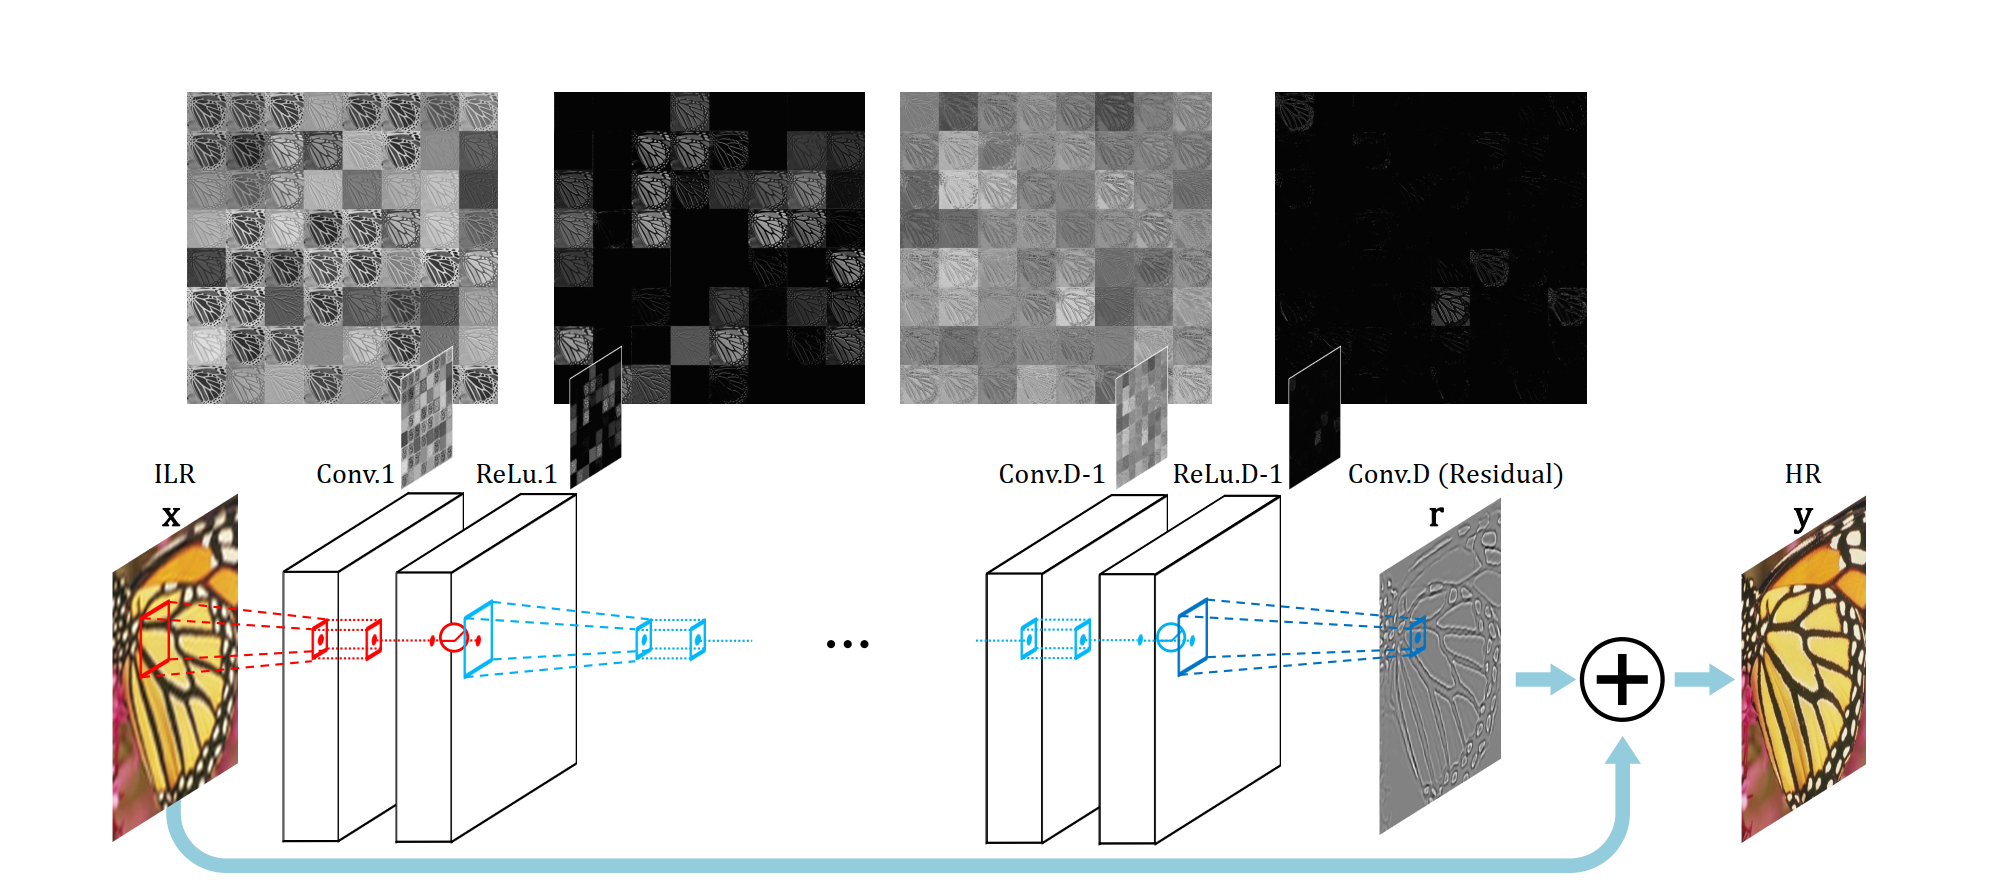

## Prepare the dataset

In [ ]:
# Unzip data to train folder
!unzip /content/drive/MyDrive/dataset/train_data.zip -d /content/drive/MyDrive/dataset/train

### Extract patches from HR images

Number of images: 291


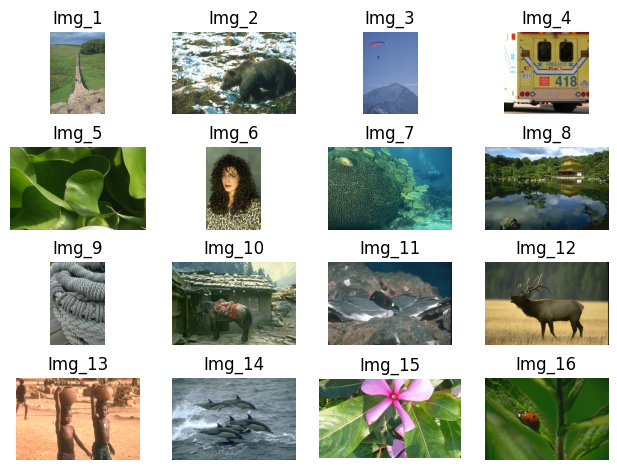

In [3]:
import PIL
from PIL import Image

# Data visualization
path = '/kaggle/input/vdsr-dataset/train_data/291'
img_path = []

# Load image path
for img_name in os.listdir(path):
      img_path.append(os.path.join(path, img_name))
print(f'Number of images: {len(img_path)}')

# Visual image
f, axis = plt.subplots(4, 4, tight_layout=True)
for i in range(4):
    for j in range(4):
        img = Image.open(img_path[i*4+j])
        axis[i][j].imshow(img)
        axis[i][j].set_title('Img_' + str(i*4+j+1))
        axis[i][j].axis("off")
plt.show()

(25, 16, 5043)


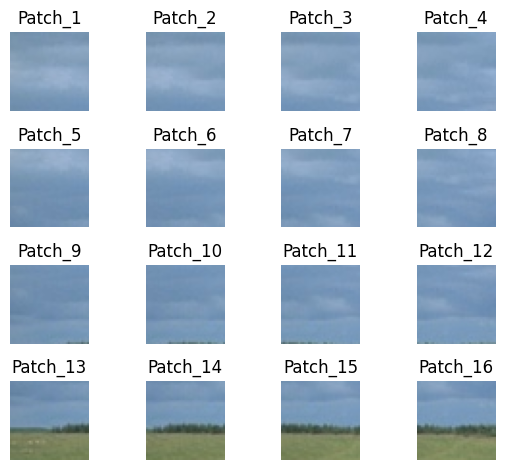

In [4]:
test_img = Image.open(img_path[0])
test_img = tf.expand_dims(test_img, 0)
test_patches = tf.image.extract_patches(np.array(test_img), [1,41,41,1], [1,18,18,1],[1, 1, 1, 1],'VALID')[0]
print(test_patches.shape)

# View patches
f, axis = plt.subplots(min(test_patches.shape[0], 4), min(test_patches.shape[1], 4), tight_layout=True)
for i in range(min(test_patches.shape[0], 4)):
      for j in range(min(test_patches.shape[1], 4)):
        img = tf.reshape(test_patches[i][j], [41, 41, -1])
        axis[i][j].imshow(img)
        axis[i][j].set_title('Patch_' + str(i*4+j+1))
        axis[i][j].axis("off")

In [ ]:
test_patches = tf.reshape(test_patches, [test_patches.shape[0]*test_patches.shape[1], -1])

In [ ]:
count = 0
for i in test_patches:
 print(i)
 count+=1
print(count)

In [5]:
def extract_patches(image, size=41, stride=20):
    extract_img = []
    # Extract patches from image
    expand_img = tf.expand_dims(image, 0)
    patches = tf.image.extract_patches(
          np.array(expand_img),
          [1,size,size,1],
          [1,stride,stride,1],
          [1, 1, 1, 1],
          'VALID')[0]
    # Reshape and add patches to training data
    patches = tf.reshape(patches, [patches.shape[0] * patches.shape[1], -1])
    for patch in patches:
        img = tf.reshape(patch, [size, size, -1])
        extract_img.append(img)
    return extract_img

In [6]:
# Load data as patches
train_imgs = []
for name in img_path:
    # Load image
    pil_img = Image.open(name)
    img = np.array(pil_img)
    # Extract patch with size 41x41
    train_imgs += extract_patches(img)
    sys.stdout.write('\rExtract patches from image: %s successfully!' %name)
    sys.stdout.flush()
print('\nFinish extracting patches!')

# Convert train_imgs to numpy array for training dataset
train_y = (np.asarray(train_imgs).astype('float32') / 255.)
print(train_y.shape)
print(np.min(train_y[0]))
print(np.max(train_y[0]))

Extract patches from image: /kaggle/input/vdsr-dataset/train_data/291/151087.jpg successfully!!
Finish extracting patches!
(79280, 41, 41, 3)
0.42352942
0.827451


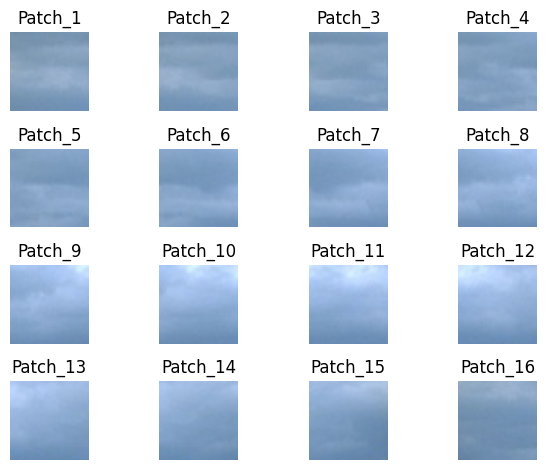

In [7]:
# Visualize some patches
f, axis = plt.subplots(4, 4, tight_layout=True)
for i in range(4):
    for j in range(4):
        img = train_y[i*4+j]
        axis[i][j].imshow(img)
        axis[i][j].set_title('Patch_' + str(i*4+j+1))
        axis[i][j].axis("off")
plt.show()

### Data preparation

In [8]:
import random
from tensorflow import keras
from keras import backend as K
from keras import layers
from keras import optimizers

In [9]:
import random

# Generate train_x
train_data = []
def gen_lr_img(hr_imgs, shape=(41, 41), scale=[2, 3, 4]):
    for img in hr_imgs:
        s = random.choice(scale)
        downscale = cv2.resize(img, None, fx=1/s, fy=1/s, interpolation=cv2.INTER_CUBIC)
        lr_img = cv2.resize(downscale, shape, interpolation=cv2.INTER_CUBIC)
        train_data.append(lr_img)

gen_lr_img(train_y)
# Convert to numpy array
train_x = np.asarray(train_data).astype('float32')
print(train_x.shape)

(79280, 41, 41, 3)


## Design the model

In [10]:
import cv2
import os
import sys
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import layers
from keras import optimizers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import PIL
from PIL import Image

**Training phase:**

**Input**: 41x41x3 patch of lr_images

**Model**: Input layer -> 19 (conv+relu) layers -> residual layer

**Output**: corresponding hr patch

In [18]:
# Custom conv layer
def Conv_Layer(input, filter=64, kernel=(3, 3)):
    x = layers.Conv2D(filter, kernel, padding='same', kernel_initializer='he_normal')(input)
    x = layers.ReLU()(x)
    return x

# Model definition
def VDSR():
    input = keras.Input(shape=(None, None, 3), name="image_input")
    x = Conv_Layer(input)
    for i in range(18):
        x = Conv_Layer(x)
    x = layers.Conv2D(3, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    output = layers.add([x, input])
    model = keras.Model(input, output, name='VDSR')
    model.summary()
    return model


In [19]:
# Use single gpu for evaluation and prediction

# PSNR metric
def PSNR(super_resolution, high_resolution):
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=1.)[0]
    return psnr_value

model = VDSR()
# Compile model
model.compile(
        loss=keras.losses.MSE,
        optimizer=keras.optimizers.Adam(0.00001),
        metrics=[PSNR, 'accuracy'],
)

Model: "VDSR"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, None,      │      1,792 │ image_input[0][0] │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, None,      │          0 │ conv2d_20[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, None,      │     36,928 │ re_lu_19[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, None,      │          0 │ conv2d_21[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, None,      │     36,928 │ re_lu_20[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_21 (ReLU)     │ (None, None,      │          0 │ conv2d_22[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, None,      │     36,928 │ re_lu_21[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_22 (ReLU)     │ (None, None,      │          0 │ conv2d_23[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, None,      │     36,928 │ re_lu_22[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_23 (ReLU)     │ (None, None,      │          0 │ conv2d_24[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, None,      │     36,928 │ re_lu_23[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_24 (ReLU)     │ (None, None,      │          0 │ conv2d_25[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, None,      │     36,928 │ re_lu_24[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_25 (ReLU)     │ (None, None,      │          0 │ conv2d_26[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, None,      │     36,928 │ re_lu_25[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_26 (ReLU)     │ (None, None,      │          0 │ conv2d_27[0][0] 

 Total params: 668,227 (2.55 MB)

 Trainable params: 668,227 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# PSNR metric
def PSNR(super_resolution, high_resolution):
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=1.)[0]
    return psnr_value

# Use dual-gpu for training
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():
    model = VDSR()
    # Compile model
    model.compile(
        loss=keras.losses.MSE,
        optimizer=keras.optimizers.Adam(0.00001),
        metrics=[PSNR, 'accuracy'],
    )

Number of devices: 2


Model: "VDSR"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │      1,792 │ image_input[0][0] │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, None,      │          0 │ conv2d[0][0]      │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, None,      │     36,928 │ re_lu[0][0]       │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, None,      │          0 │ conv2d_1[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, None,      │     36,928 │ re_lu_1[0][0]     │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, None,      │          0 │ conv2d_2[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, None,      │     36,928 │ re_lu_2[0][0]     │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, None,      │          0 │ conv2d_3[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, None,      │     36,928 │ re_lu_3[0][0]     │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, None,      │          0 │ conv2d_4[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, None,      │     36,928 │ re_lu_4[0][0]     │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, None,      │          0 │ conv2d_5[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, None,      │     36,928 │ re_lu_5[0][0]     │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_6 (ReLU)      │ (None, None,      │          0 │ conv2d_6[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, None,      │     36,928 │ re_lu_6[0][0]     │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_7 (ReLU)      │ (None, None,      │          0 │ conv2d_7[0][0]  

 Total params: 668,227 (2.55 MB)

 Trainable params: 668,227 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Start training
EPOCHS = 30
BATCH_SIZE = 64
VALIDATION = 0.25

history = model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VALIDATION, shuffle=True)

Epoch 1/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 111s 99ms/step - accuracy: 1.5510 - loss: 0.0385 - psnr: 45.8063 - val_accuracy: 0.8912 - val_loss: 0.0044 - val_psnr: 27.5467
Epoch 2/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 88s 94ms/step - accuracy: 1.8086 - loss: 0.0104 - psnr: 53.1411 - val_accuracy: 0.9132 - val_loss: 0.0042 - val_psnr: 28.0838
Epoch 3/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 88s 94ms/step - accuracy: 1.8376 - loss: 0.0101 - psnr: 54.1262 - val_accuracy: 0.9196 - val_loss: 0.0041 - val_psnr: 28.2855
Epoch 4/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 87s 94ms/step - accuracy: 1.8499 - loss: 0.0099 - psnr: 55.0295 - val_accuracy: 0.9243 - val_loss: 0.0040 - val_psnr: 28.4327
Epoch 5/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 87s 94ms/step - accuracy: 1.8553 - loss: 0.0098 - psnr: 55.1199 - val_accuracy: 0.9270 - val_loss: 0.0040 - val_psnr: 28.4729
Epoch 6/30
930/930 ━━━━━━━━━━━━━━━━━━━━ 87s 94ms/step - accuracy: 1.8596 - loss: 0.0097 - psnr: 54.3025 - val_accuracy: 0.9286 - val_loss: 0.0040 - val_psnr: 28.5074
Epo

In [16]:
# Start training
EPOCHS = 80
BATCH_SIZE = 64
VALIDATION = 0.25

history = model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VALIDATION, shuffle=True, initial_epoch=49)

Epoch 50/80
930/930 ━━━━━━━━━━━━━━━━━━━━ 86s 93ms/step - accuracy: 1.8949 - loss: 0.0079 - psnr: 56.8233 - val_accuracy: 0.9461 - val_loss: 0.0033 - val_psnr: 29.5786
Epoch 51/80
930/930 ━━━━━━━━━━━━━━━━━━━━ 84s 90ms/step - accuracy: 1.8955 - loss: 0.0079 - psnr: 56.5545 - val_accuracy: 0.9462 - val_loss: 0.0033 - val_psnr: 29.6446
Epoch 52/80
930/930 ━━━━━━━━━━━━━━━━━━━━ 84s 90ms/step - accuracy: 1.8964 - loss: 0.0079 - psnr: 57.8090 - val_accuracy: 0.9449 - val_loss: 0.0033 - val_psnr: 29.6020
Epoch 53/80
930/930 ━━━━━━━━━━━━━━━━━━━━ 84s 90ms/step - accuracy: 1.8956 - loss: 0.0080 - psnr: 57.1510 - val_accuracy: 0.9456 - val_loss: 0.0033 - val_psnr: 29.5502
Epoch 54/80
930/930 ━━━━━━━━━━━━━━━━━━━━ 85s 91ms/step - accuracy: 1.8969 - loss: 0.0079 - psnr: 58.2422 - val_accuracy: 0.9454 - val_loss: 0.0033 - val_psnr: 29.5722
Epoch 55/80
930/930 ━━━━━━━━━━━━━━━━━━━━ 84s 91ms/step - accuracy: 1.8978 - loss: 0.0078 - psnr: 58.0747 - val_accuracy: 0.9461 - val_loss: 0.0032 - val_psnr: 29.657

In [17]:
# Save model weight
model.save_weights("VDSR_v3.weights.h5")
del model

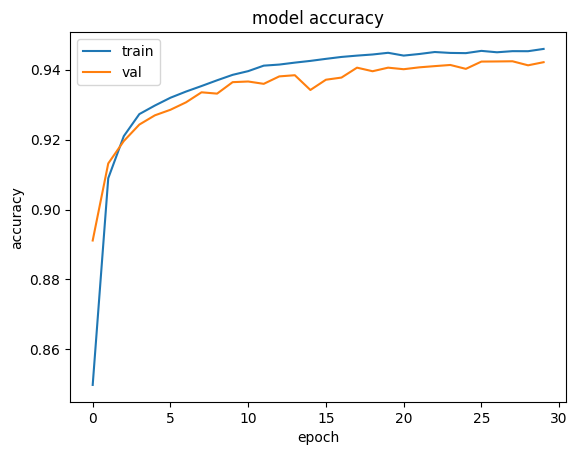

In [20]:
# Accuracy graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

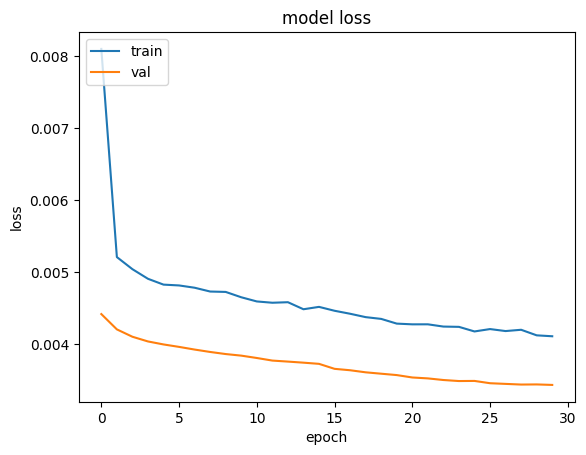

In [21]:
# Loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Model evaluation

In [21]:
# PSNR metric
def PSNR(super_resolution, high_resolution):
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=1.0)[0]
    return psnr_value

# SSIM metric
def SSIM(super_resolution, high_resolution):
    ssim_value = tf.image.ssim(high_resolution, super_resolution, max_val=1.0)[0]
    return ssim_value

In [ ]:
# Load model weight for evaluation
model_path = 'VDSR_v3.weights.h5'
model.load_weights(model_path)

In [22]:
# Load set 5 dataset for model evaluation
path = '/kaggle/input/vdsr-dataset/test_data/Set5' # Change to your path!!!!!!

# List of data
test_x = []
test_y = []
names = []

scale = [2, 3, 4]

# Generate lr images for evaluation
for name in os.listdir(path):
    names.append(name)
    gt_img = np.array(Image.open(os.path.join(path, name)))
    lr_img = cv2.resize(gt_img, None, fx=1./scale[2], fy=1./scale[2], interpolation=cv2.INTER_CUBIC)
    lr_img = cv2.resize(lr_img, (gt_img.shape[1], gt_img.shape[0]), interpolation=cv2.INTER_CUBIC)
    test_x.append(lr_img)
    test_y.append(gt_img)
    
# Check shape
print(test_x[2].shape)
print(test_y[2].shape)

(288, 288, 3)
(288, 288, 3)


In [23]:
# Evaluation:
eval = []
for i in range(len(test_x)):
    expand_test_x = (tf.expand_dims(test_x[i], 0))
    expand_test_y = (tf.expand_dims(test_y[i], 0))
    eval.append(model.evaluate(expand_test_x/255, expand_test_y/255))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9827 - loss: 0.0087 - psnr: 20.5969


I0000 00:00:1712466143.756459      89 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9932 - loss: 0.0034 - psnr: 24.6897
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9462 - loss: 0.0020 - psnr: 26.9371
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9714 - loss: 0.0015 - psnr: 28.1188
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9724 - loss: 0.0011 - psnr: 29.6501


In [24]:
print('VDSR evaluation')
total = 0
for i in range(len(eval)):
  total += eval[i][2]
print(f'Mean PSNR: {total/len(eval)}')

VDSR evaluation
Mean PSNR: 25.99852294921875


In [25]:
print('Bicubic interpolation')
psnrs = []
for i in range(len(test_x)):
  expand_test_x = tf.expand_dims(test_x[i], 0)
  expand_test_y = tf.expand_dims(test_y[i], 0)
  psnr = PSNR(expand_test_x/255, expand_test_y/255)
  print(f'Psnr: {psnr}')
  psnrs.append(psnr)

print(f'Mean PSNR: {np.mean(psnrs)}')

Bicubic interpolation
Psnr: 19.996551513671875
Psnr: 24.445669174194336
Psnr: 27.630298614501953
Psnr: 27.916545867919922
Psnr: 29.699979782104492
Mean PSNR: 25.93781089782715


In [26]:
import os

# Model predict on set 5 dataset 4x downscale
predict_path = '/content/drive/MyDrive/dataset/test/Set5/Predict' # or your image path
predict = []
for i in range(len(test_x)):
  expand_test_x = (tf.expand_dims(test_x[i], 0))
  predict.append(model.predict(expand_test_x/255))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


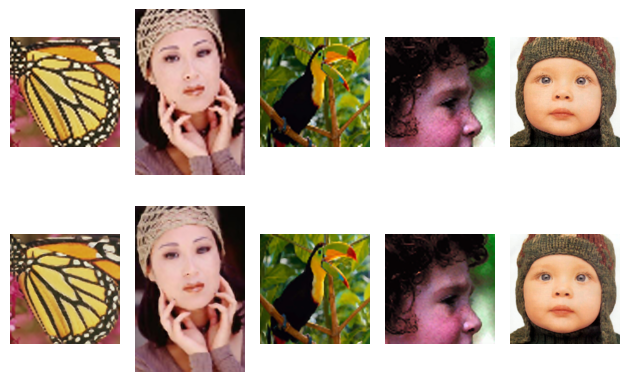

In [27]:
f, axis = plt.subplots(2, 5, tight_layout=True)
for i in range(2):
  for j in range(5):
    if i == 0:
      axis[i][j].imshow(test_x[j])
    else:
      axis[i][j].imshow(predict[j][0])
    axis[i][j].axis("off")

In [70]:
# Save predict 
for i in range(5):
    img = Image.fromarray((predict[i][0]*255).astype('uint8'))
    save_path = os.path.join('/kaggle/working/', names[i])
    img.save(save_path)